Copyright © 2021, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Imports

In [1]:
import swat
import os
import sys
import re
import pandas as pd
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../../common/python"))
import visualization as viz
import cas_connection as cas

# CAS Connection

In [2]:
s=cas.reconnect()
s.loadActionSet('network')
s.loadActionSet('fcmpact')

NOTE: Added action set 'network'.
NOTE: Added action set 'fcmpact'.


[actionset]

 'fcmpact'

+ Elapsed: 0.0011s, mem: 0.205mb

# Generate Word Embeddings

Assign weights to word pairs (1 = perfect synonym, 0 = unrelated word).
In practice, pre-trained word embeddings could be used instead of learning them here.
These would typically be trained based on co-occurence frequency in a large corpus.

In [3]:
synonym_links = [['music', 'dvd', 0.1],
                ['music', 'mp3', 0.9],
                ['music', 'video', 0.3],
                ['book', 'mp3', 0.1],
                ['dvd', 'video', 0.95],
                ['mp3', 'video', 0.1]]
df_synonym_links = pd.DataFrame(synonym_links, columns = ['from', 'to', 'weight']) 
s.upload(df_synonym_links, casout = {'name':'synonymLinks', 'replace':True})
s.CASTable('synonymLinks').head(6)

NOTE: Cloud Analytic Services made the uploaded file available as table SYNONYMLINKS in caslib CASUSER(brrees).
NOTE: The table SYNONYMLINKS has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.


,from,to,weight
0,music,dvd,0.10
1,music,mp3,0.90
2,music,video,0.30
3,book,mp3,0.10
4,dvd,video,0.95
5,mp3,video,0.10


Train word embeddings using vector node similarity, first order proximity

In [4]:
n_dim=10
convergence_threshold=0.00001
n_samples=1000000
result =  s.network.nodeSimilarity(
    links                = {"name":"synonymLinks"},
    vector               = True,
    jaccard              = False,
    convergenceThreshold = convergence_threshold,
    nSamples             = n_samples,
    nDimensions          = n_dim,
    proximityOrder       = "first",
    outSimilarity        = {"name":"outSim",  "replace":True},
    outNodes             = {"name":"wordEmbeddings",  "replace":True}
)

NOTE: The number of nodes in the input graph is 5.
NOTE: The number of links in the input graph is 6.
NOTE: Processing node similarity using 16 threads across 1 machines.
NOTE: Using a single thread for vector space calculation because DETERMINISTIC=TRUE.
NOTE: Processing the node vector space used 0.91 (cpu: 0.68) seconds.
NOTE: Processing node similarity between 5 source nodes and 5 sink nodes.
NOTE: Processing node similarity used 0.91 (cpu: 0.68) seconds.


Show the word similarity computed based on trained embeddings

In [5]:
grouped_df = s.CASTable('outSim').to_frame().groupby('source')

for key, item in grouped_df:
    display(grouped_df.get_group(key).head(100))

,source,sink,link,vector
0,book,book,0.0,1.00
1,book,dvd,0.0,0.50
2,book,mp3,1.0,0.55
3,book,music,0.0,0.50
4,book,video,0.0,0.50


,source,sink,link,vector
5,dvd,dvd,0.0,1.000
6,dvd,mp3,0.0,0.500
7,dvd,music,1.0,0.550
8,dvd,video,1.0,0.975


,source,sink,link,vector
9,mp3,mp3,0.0,1.00
10,mp3,music,1.0,0.95
11,mp3,video,1.0,0.55


,source,sink,link,vector
12,music,music,0.0,1.00
13,music,video,1.0,0.65


,source,sink,link,vector
14,video,video,0.0,1.0


# Approximate Pattern Matching Based on Word Embeddings

## Main graph: purchase history for 6 people for 5 categories of products

In [6]:
nodes_purchase = [['1',     'person', 'Amy'],
                 ['2',     'person', 'Blaine'],
                 ['3',     'person', 'Catherine'],
                 ['4',     'person', 'Dexter'],
                 ['5',     'person', 'Edwin'],
                 ['6',     'person', 'Faye'],
                 ['MUSIC1','music',  'Dark_Side_of_the_Moon'],
                 ['MUSIC2','music',  'Led_Zeppelin'],
                 ['MP3A',  'mp3',    'Back_in_Black'],
                 ['MP3B',  'mp3',    'From_This_Moment_On'],
                 ['VIDEO1','video',  'Star_Wars'],
                 ['DVD1',  'dvd',    'The_West_Wing'],
                 ['DVD2',  'dvd',    'King_Kong'],
                 ['BOOK1', 'book',   'Catcher_in_the_Rye'],
                 ['BOOK2', 'book',   'Little_Women'],
                 ['BOOK3', 'book',   'The_Bell_Jar']]
links_purchase = [['1', 'MUSIC1'],
                 ['1', 'MP3A'],
                 ['1', 'VIDEO1'],
                 ['2', 'MUSIC1'],
                 ['2', 'MP3A'],
                 ['3', 'VIDEO1'],
                 ['3', 'MUSIC1'],
                 ['3', 'DVD1'],
                 ['3', 'DVD2'],
                 ['3', 'BOOK1'],
                 ['4', 'MP3A'],
                 ['4', 'BOOK1'],
                 ['4', 'BOOK2'],
                 ['4', 'BOOK3'],
                 ['5', 'MP3B'],
                 ['5', 'MUSIC2'],
                 ['5', 'DVD1'],
                 ['5', 'DVD2'],
                 ['5', 'VIDEO1'],
                 ['6', 'DVD2'],
                 ['6', 'VIDEO1'],
                 ['6', 'BOOK3'],
                 ['6', 'MP3A']]
df_nodes_purchase = pd.DataFrame(nodes_purchase, columns = ['node', 'type', 'longName'])
df_links_purchase = pd.DataFrame(links_purchase, columns = ['from', 'to'])
s.upload(df_nodes_purchase, casout = {'name':'nodesPurchase', 'replace':True})
s.upload(df_links_purchase, casout = {'name':'linksPurchase', 'replace':True})

NOTE: Cloud Analytic Services made the uploaded file available as table NODESPURCHASE in caslib CASUSER(brrees).
NOTE: The table NODESPURCHASE has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table LINKSPURCHASE in caslib CASUSER(brrees).
NOTE: The table LINKSPURCHASE has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(brrees)'

[tableName]

 'LINKSPURCHASE'

[casTable]

 CASTable('LINKSPURCHASE', caslib='CASUSER(brrees)')

+ Elapsed: 0.00382s, user: 0.003s, sys: 0.001s, mem: 33.3mb

### Add color and label columns

In [7]:
s.datastep.runCode(
    code="""
        data nodesPurchase;
            set nodesPurchase;
            length color $8 label $52;
            if      type EQ 'music' then color='1';
            else if type EQ 'mp3'   then color='2';
            else if type EQ 'video' then color='3';
            else if type EQ 'dvd'   then color='4';
            else if type EQ 'book'  then color='5';
            else                         color='white';
            label = CATS(longName,'\n','(',type,')');
    """
)
s.CASTable('nodesPurchase').head(16)

,node,type,longName,color,label
0,1,person,Amy,white,Amy\n(person)
1,2,person,Blaine,white,Blaine\n(person)
2,3,person,Catherine,white,Catherine\n(person)
3,4,person,Dexter,white,Dexter\n(person)
4,5,person,Edwin,white,Edwin\n(person)
5,6,person,Faye,white,Faye\n(person)
6,MUSIC1,music,Dark_Side_of_the_Moon,1,Dark_Side_of_the_Moon\n(music)
7,MUSIC2,music,Led_Zeppelin,1,Led_Zeppelin\n(music)
8,MP3A,mp3,Back_in_Black,2,Back_in_Black\n(mp3)
9,MP3B,mp3,From_This_Moment_On,2,From_This_Moment_On\n(mp3)


## Query graph: find pair of persons who purchased the same 2 video items

In [8]:
nodes_query = [['Person1', 'person'],
              ['Person2', 'person'],
              ['Video1',  'video' ],
              ['Video2',  'video' ]]
links_query = [['Person1', 'Video1'],
              ['Person1', 'Video2'],
              ['Person2', 'Video1'],
              ['Person2', 'Video2']]
df_nodes_query = pd.DataFrame(nodes_query, columns = ['node', 'type'])
df_links_query = pd.DataFrame(links_query, columns = ['from', 'to'])
s.upload(df_nodes_query, casout = {'name':'nodesQuery', 'replace':True})
s.upload(df_links_query, casout = {'name':'linksQuery', 'replace':True})

NOTE: Cloud Analytic Services made the uploaded file available as table NODESQUERY in caslib CASUSER(brrees).
NOTE: The table NODESQUERY has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table LINKSQUERY in caslib CASUSER(brrees).
NOTE: The table LINKSQUERY has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(brrees)'

[tableName]

 'LINKSQUERY'

[casTable]

 CASTable('LINKSQUERY', caslib='CASUSER(brrees)')

+ Elapsed: 0.00524s, user: 0.001s, sys: 0.002s, mem: 33.2mb

### Merge nodes with word embeddings

In [9]:
s.dataStep.runCode(
    code = ''' data casuser.nodesQueryEmbed;
               merge casuser.nodesQuery(in = nodeIn) casuser.wordEmbeddings(rename=(node=type));
               by type;
               if nodeIn;
               run;'''
)
s.dataStep.runCode(
    code = ''' data casuser.nodesPurchaseEmbed;
               merge casuser.nodesPurchase(in = nodeIn) casuser.wordEmbeddings(rename=(node=type));
               by type;
               if nodeIn;
               run;'''
)

[InputCasTables]

             casLib            Name  Rows  Columns  \
 0  CASUSER(brrees)   nodesPurchase    16        5   
 1  CASUSER(brrees)  wordEmbeddings     5       11   
 
                                             casTable  
 0  CASTable('nodesPurchase', caslib='CASUSER(brre...  
 1  CASTable('wordEmbeddings', caslib='CASUSER(brr...  

[OutputCasTables]

             casLib                Name  Rows  Columns  Append Promoted  \
 0  CASUSER(brrees)  nodesPurchaseEmbed    16       15     NaN        N   
 
                                             casTable  
 0  CASTable('nodesPurchaseEmbed', caslib='CASUSER...  

+ Elapsed: 0.039s, user: 0.036s, sys: 0.107s, mem: 12.2mb

## Define FCMP function for fuzzy match

In [10]:
# Generate expressions for fcmp variable list 
vars_comma_n = ', '.join([f'n.vec_{i}, nQ.vec_{i}'  for i in range(n_dim)])
vars_dotproduct_n = '+ '.join([f'n.vec_{i}*nQ.vec_{i}' for i in range(n_dim)])

# Consider two types to be equivalent if the vector dot product value exceeds this threshold
fuzzy_match_threshold=0.7

In [11]:
s.addRoutines(
    routineCode = f'''
     /** Node filter: we require exact match for type=person, approximate match otherwise **/
      function nodeFilter(n.type $, nQ.type $, {vars_comma_n});
         if (nQ.type EQ 'person') then return (n.type EQ nQ.type);
         if ({vars_dotproduct_n} > {fuzzy_match_threshold}) then return (1);
         return (0);
      endsub;
      /** Node pair filter: don't enumerate redundant (symmetric) permutations **/
      function nodePairFilter(n.node[*] $, nQ.node[*] $);
         if(nQ.node[1] EQ 'Person1' AND nQ.node[2] EQ 'Person2') then return (n.node[1] LT n.node[2]);
         if(nQ.node[1] EQ 'Video1' AND nQ.node[2] EQ 'Video2') then return (n.node[1] LT n.node[2]);
         return (1);
      endsub;        
    ''',
    package   = "myPackage",
    saveTable = True,
    funcTable = {"name":"myRoutines", "caslib":"casuser","replace":True}
) 
s.sessionProp.setSessOpt(cmplib = "casuser.myRoutines")

NOTE: Cloud Analytic Services saved the file MYROUTINES.sashdat in caslib CASUSER(brrees).


+ Elapsed: 0.000273s, sys: 0.001s, mem: 0.262mb

## Approximate PatternMatch

In [12]:
nodes_var = ["type", "longName"]
nodes_var.extend([f"vec_{i}" for i in range(n_dim)])
nodes_query_var = ["type"]
nodes_query_var.extend([f"vec_{i}" for i in range(n_dim)])
result = s.network.patternMatch(
    direction      = "directed",
    nodes          = {"name":"nodesPurchaseEmbed"},
    links          = {"name":"linksPurchase"},
    nodesQuery     = {"name":"nodesQueryEmbed"},
    linksQuery     = {"name":"linksQuery"},
    nodesVar       = {"vars": nodes_var},
    nodesQueryVar  = {"vars": nodes_query_var, "varsMatch" : []},
    nodePairFilter = "nodePairFilter(n.node, nQ.node)",
    nodeFilter     = f"nodeFilter(n.type, nQ.type, {vars_comma_n})",
    outMatchNodes  = {"name":"outMatchNodes", "replace":True},
    outMatchLinks  = {"name":"outMatchLinks", "replace":True} 
)
num_matches = result.numMatches

NOTE: The number of nodes in the input graph is 16.
NOTE: The number of links in the input graph is 23.
NOTE: The number of nodes in the query graph is 4.
NOTE: The number of links in the query graph is 4.
NOTE: Processing the pattern matching query using 16 threads across 1 machines.
NOTE: The algorithm found 5 matches.
NOTE: Processing the pattern matching query used 0.00 (cpu: 0.00) seconds.


## Input Graph Visualization

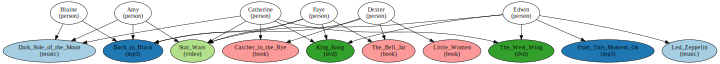

In [13]:
viz.graph2dot(nodesDf    = s.CASTable('nodesPurchase'),
             linksDf    = s.CASTable('linksPurchase'), 
             directed   = 1,
             nodesLabel = "label",
             nodesAttrs = {"colorscheme":"paired8", "style":"filled", "shape":"oval", "color":"black"},
             nodeAttrs  = {"fillcolor":"color", "label":"label"},
             graphAttrs = {"layout":"dot", "rankdir":"TB"},
             stdout=False
            )

## Query Graph Visualization

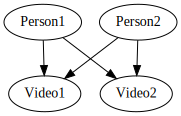

In [14]:
viz.graph2dot(
             linksDf    = s.CASTable('linksQuery'), 
             directed   = 1,
             nodesAttrs = {"shape":"oval"},
             graphAttrs = {"layout":"dot", "rankdir":"TB"},
             size       = 5,
             stdout     = False
            )

## Matches Found Visualization

In [15]:
highlightColor = 'blue'
highlightThickness = 3

def find_match(selectedMatch):
    s.dataStep.runCode(
       code = f'''
       data casuser.linksPurchaseHighlighted;
       merge casuser.linksPurchase
             casuser.outMatchLinks(in=inMatch where=(match={selectedMatch}));
       by from to;
       if inMatch then do;
          color= "{highlightColor}";
          thickness={highlightThickness};
       end;
       run;''')
        
    s.dataStep.runCode(
       code = f''' 
       data casuser.nodesPurchaseHighlighted;
       merge casuser.nodesPurchase
       casuser.outMatchNodes(in=inMatch where=(match={selectedMatch}));
       by node;
       if inMatch then do;
          pencolor="{highlightColor}";
          thickness={highlightThickness};
       end; 
       run;
       '''
    )
    return viz.graph2dot(
                nodesDf    = s.CASTable('nodesPurchaseHighlighted'),
                linksDf    = s.CASTable('linksPurchaseHighlighted'), 
                nodesAttrs = {"colorscheme":"paired8", "style":"filled", "shape":"oval", "color":"black"},
                nodeAttrs  = {"fillcolor":"color", "label":"label", "color":"pencolor", "penwidth":"thickness"},
                linkAttrs  = {"color":"color", "penwidth":"thickness"},
                graphAttrs = {"layout":"dot", "rankdir":"TB"},
                directed   = 1,
                stdout     = False
                )  

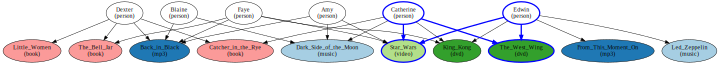

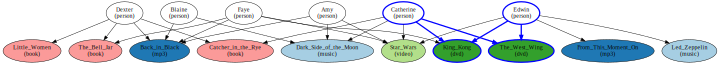

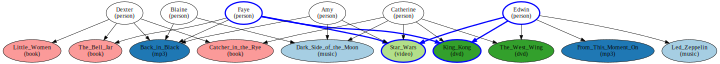

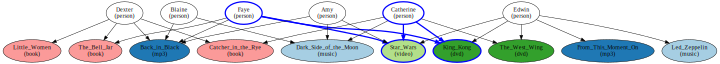

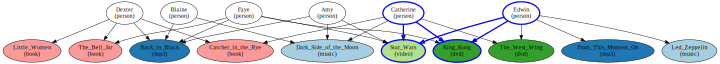

In [16]:
for selected_match in range(num_matches):
    display(find_match(selected_match))